### Import Libraries

In [1]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import nltk
import string
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import random
import matplotlib.pyplot as plt

### Set seed for reproducibility

In [2]:
seed = 0

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

### Download pretrained word embeddings

In [3]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [4]:
vocab = list(word2vec.index_to_key)
vocab_size = len(word2vec.index_to_key)
embedding_dim = 300

### Import Dataset

In [5]:
train_df = pd.read_csv('dataset part 2/train.csv')
test_df = pd.read_csv("dataset part 2/test.csv")
train_df.drop(columns=['label-fine'], inplace=True)
test_df.drop(columns=['label-fine'], inplace=True)

In [6]:
train_df

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?
...,...,...
5447,1,What 's the shape of a camel 's spine ?
5448,1,What type of currency is used in China ?
5449,4,What is the temperature today ?
5450,4,What is the temperature for cooking ?


Form a development set from a random subset (containing 500 examples) within the original training data. Remove these examples from original training file

In [7]:
development_df = train_df.sample(n=500, random_state=0) # randomly sample 500 rows from train df
train_df = train_df.drop(development_df.index) # remove sampled rows from train df

In [8]:
development_df

,label-coarse,text
2755,4,How many trees go into paper making in a year ?
3326,1,What concerts are held in New York this week ?
2204,5,Where did the sport of caber-tossing originate ?
2888,3,What kind of people took part in Shays ' Rebel...
2812,0,How is cologne made ?
...,...,...
5335,5,Where was George Washington born ?
1275,4,In what year did the Bounty mutiny happen ?
4508,0,What is the difference between khaki and chino ?
402,4,How many types of dogs ' tails are there - three


Randomly select 4 classes from 6 coarse labels, combine remaining 2 to form a single class 'OTHERS'. Adjust original data such that label for each sentence is updated accordingly

In [9]:
# Selected 2 labels for combining
combined_1 = 4
combined_2 = 5

# train_df['label-coarse'] = train_df['label-coarse'].astype(object)
# test_df['label-coarse'] = train_df['label-coarse'].astype(object)
# development_df['label-coarse'] = train_df['label-coarse'].astype(object)

# Assign label 5 as 4 as the OTHERS label
train_df.loc[(train_df['label-coarse'] == combined_2), 'label-coarse'] = combined_1
test_df.loc[(test_df['label-coarse'] == combined_2), 'label-coarse'] = combined_1
development_df.loc[(development_df['label-coarse'] == combined_2), 'label-coarse'] = combined_1

### Tokenize and remove punctuation

In [10]:
from nltk.tokenize import word_tokenize

def tokenize_and_remove_punctuation(text):
    # Create a translation table to replace punctuation with empty strings
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuation and replace with ''
    text_ = text.translate(translator)
    tokens = word_tokenize(text_)
    # filtered_tokens = [token for token in tokens if token in vocab]
    return tokens

In [11]:
train_df['text'] = train_df['text'].apply(lambda x: tokenize_and_remove_punctuation(x))
test_df['text'] = test_df['text'].apply(lambda x: tokenize_and_remove_punctuation(x))
development_df['text'] = development_df['text'].apply(lambda x: tokenize_and_remove_punctuation(x))

### Padding of Data for LSTM

In [12]:
# def pad_tokens(tokens, max_length, padding_value='<pad>'):
#     if len(tokens) < max_length:
#         tokens.extend([padding_value] * (max_length - len(tokens)))
#     return tokens

In [13]:
# max_length = max(train_df['text'].apply(len))

In [14]:
# train_df['text'] = train_df['text'].apply(pad_tokens, max_length=max_length)
# test_df['text'] = test_df['text'].apply(pad_tokens, max_length=max_length)
# development_df['text'] = development_df['text'].apply(pad_tokens, max_length=max_length)

### Get embedding matrix for embedding layer

In [15]:
embedding_matrix = word2vec.vectors

In [16]:
embedding_matrix.shape

(3000000, 300)

### Last element a zero array for out of vocab words

In [17]:
zero_array = np.zeros((300,))
embedding_matrix = np.vstack((embedding_matrix, zero_array)) # last element a zero array for OOV words

### Encode text in dataframe to indices

In [18]:
def tokens_to_indices(tokens, model):
    indices = []
    for token in tokens:
        try:
            indices.append(model.get_index(token))
        except:
            indices.append(len(embedding_matrix)-1)  # Handle out-of-vocabulary words
    return indices

In [19]:
train_df['word_indices'] = train_df['text'].apply(lambda x: tokens_to_indices(x, word2vec))
test_df['word_indices'] = test_df['text'].apply(lambda x: tokens_to_indices(x, word2vec))
development_df['word_indices'] = development_df['text'].apply(lambda x: tokens_to_indices(x, word2vec))

In [20]:
train_df

,label-coarse,text,word_indices
0,0,"[How, did, serfdom, develop, in, and, then, le...","[1190, 92, 178836, 1306, 1, 3000000, 145, 785,..."
1,1,"[What, films, featured, the, character, Popeye...","[470, 2485, 2723, 11, 1980, 65760, 8347]"
2,0,"[How, can, I, find, a, list, of, celebrities, ...","[1190, 50, 20, 359, 3000000, 711, 3000000, 666..."
3,1,"[What, fowl, grabs, the, spotlight, after, the...","[470, 43119, 10673, 11, 6236, 55, 11, 1035, 16..."
4,2,"[What, is, the, full, form, of, com]","[470, 4, 11, 335, 815, 3000000, 18117]"
...,...,...,...
5447,1,"[What, s, the, shape, of, a, camel, s, spine]","[470, 1280, 11, 2790, 3000000, 3000000, 28380,..."
5448,1,"[What, type, of, currency, is, used, in, China]","[470, 1474, 3000000, 2325, 4, 233, 1, 367]"
5449,4,"[What, is, the, temperature, today]","[470, 4, 11, 4360, 205]"
5450,4,"[What, is, the, temperature, for, cooking]","[470, 4, 11, 4360, 2, 5195]"


### Create custom dataset, collate function for dataloader and dataloaders

In [21]:
import torch
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [22]:
def collate_fn(batch):
    data, targets = zip(*batch)
    
    # Sort the batch by sequence length (optional, but can improve efficiency)
    sorted_indices = sorted(range(len(data)), key=lambda i: len(data[i]), reverse=True)
    data = [data[i] for i in sorted_indices]
    targets = [targets[i] for i in sorted_indices]

    # Create a list of sequences and their corresponding lengths
    sequences = [torch.tensor(seq) for seq in data]
    lengths = [len(seq) for seq in sequences]

    # Pad the sequences to the length of the longest sequence in the batch
    padded_sequences = pad_sequence(sequences, batch_first=True)

    # Create packed sequence for RNNs (optional, if you're using an RNN)
    # packed_sequences = pack_padded_sequence(padded_sequences, lengths, batch_first=True, enforce_sorted=False)

    return padded_sequences, torch.tensor(targets), torch.tensor(lengths)

In [23]:
train_dataset = MyCustomDataset(train_df['word_indices'].to_numpy(), train_df['label-coarse'].to_numpy())
test_dataset = MyCustomDataset(test_df['word_indices'].to_numpy(), test_df['label-coarse'].to_numpy())
development_dataset = MyCustomDataset(development_df['word_indices'].to_numpy(), development_df['label-coarse'].to_numpy())

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
development_dataloader = DataLoader(development_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

### LSTM Text Classifier Architecture

In [25]:
class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, device, aggregate='last'):
        super(LSTMTextClassifier, self).__init__()
        self.aggregate = aggregate
        # Embedding layer with pretrained word vectors
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).to(device))
        self.embedding.weight.requires_grad = False # freeze the embeddings
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        
        # Softmax Layer
        self.softmax_layer = nn.Sequential(nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim),
        nn.Softmax(dim=1))
        
    def forward(self, text, text_lengths):
        # Embed the input
        embedded = self.embedding(text)
        
        #Pack the embedded sequences to handle variable-length sequences
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)

        # Pass through the LSTM layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack the packed sequences
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        if(self.aggregate == 'last'):
            # Use the final hidden state as the representation for the sentence
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :]
            # Use max pooling to aggregate as the representation for the sentence
        elif(self.aggregate == 'max'):
            hidden, _ = torch.max(output, dim = 1)
            # Use average pooling to aggregate as the representation for the sentence
        elif(self.aggregate == 'average'):
            hidden = torch.mean(output, dim = 1)
        
        # Pass through the softmax layer
        output = self.softmax_layer(hidden)
        return output

### Declare model parameters

In [26]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)
hidden_dim = 256
output_dim = 5
vocab_size = len(word2vec.index_to_key)
embedding_dim = 300
num_layer = 1
device = torch.device('cuda')

### Train function

In [27]:
def train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs=50):
    model.to(device)
    dev_acc_per_epoch = []
    for epoch in range(num_epochs):
        model.train()
        # ======== training phase ==========
        train_loss = 0.0
        for batch in train_dataloader:
            text, labels, text_lengths = batch
            text, labels, text_lengths  = torch.tensor(text).to(device), labels.to(device), text_lengths

            optimizer.zero_grad() # clear gradients

            output = model(text, text_lengths)

            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_dataloader)
        # ====================================


        # ========== validation phase =========
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in valid_dataloader:
                text, labels, text_lengths = batch
                text, labels, text_lengths  = text.to(device), labels.to(device), text_lengths

                output = model(text, text_lengths)
                loss = loss_fn(output, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        avg_valid_loss = valid_loss / len(valid_dataloader)
        accuracy = 100 * (correct / total)
        dev_acc_per_epoch.append(accuracy)
        # =======================================
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}, Accuracy: {accuracy:.2f}%')

    print('Training complete.')

    return dev_acc_per_epoch


### Test function

In [28]:
def test(model, test_dataloader, device, loss_fn):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            text, labels, text_lengths = batch
            text, labels, text_lengths  = text.to(device), labels.to(device), text_lengths

            output = model(text, text_lengths)
            loss = loss_fn(output, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    avg_valid_loss = valid_loss / len(test_dataloader)
    accuracy = 100 * (correct / total)

    return avg_valid_loss, accuracy

# Train and test model with aggregation as taking representation of last word

In [ ]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [30]:
lstm_classifier_last = LSTMTextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,num_layer,True, device, aggregate='last')
lr = 0.001
optimizer = optim.Adam(lstm_classifier_last.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\1319915531.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).to(device))


### Train model

In [31]:
dev_acc_per_epoch = train(lstm_classifier_last, train_dataloader, development_dataloader, optimizer, loss_fn, device, num_epochs=50)

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\3171075734.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text, labels, text_lengths  = torch.tensor(text).to(device), labels.to(device), text_lengths


Epoch 1/50, Train Loss: 1.3029, Validation Loss: 1.1542, Accuracy: 75.60%
Epoch 2/50, Train Loss: 1.1098, Validation Loss: 1.0840, Accuracy: 81.80%
Epoch 3/50, Train Loss: 1.0640, Validation Loss: 1.0553, Accuracy: 85.00%
Epoch 4/50, Train Loss: 1.0284, Validation Loss: 1.0527, Accuracy: 86.00%
Epoch 5/50, Train Loss: 1.0111, Validation Loss: 1.0394, Accuracy: 86.60%
Epoch 6/50, Train Loss: 0.9972, Validation Loss: 1.0460, Accuracy: 86.20%
Epoch 7/50, Train Loss: 0.9840, Validation Loss: 1.0400, Accuracy: 86.40%
Epoch 8/50, Train Loss: 0.9768, Validation Loss: 1.0298, Accuracy: 87.20%
Epoch 9/50, Train Loss: 0.9643, Validation Loss: 1.0364, Accuracy: 86.20%
Epoch 10/50, Train Loss: 0.9610, Validation Loss: 1.0422, Accuracy: 86.00%
Epoch 11/50, Train Loss: 0.9610, Validation Loss: 1.0273, Accuracy: 87.80%
Epoch 12/50, Train Loss: 0.9550, Validation Loss: 1.0271, Accuracy: 87.80%
Epoch 13/50, Train Loss: 0.9545, Validation Loss: 1.0453, Accuracy: 85.60%
Epoch 14/50, Train Loss: 0.9526, V

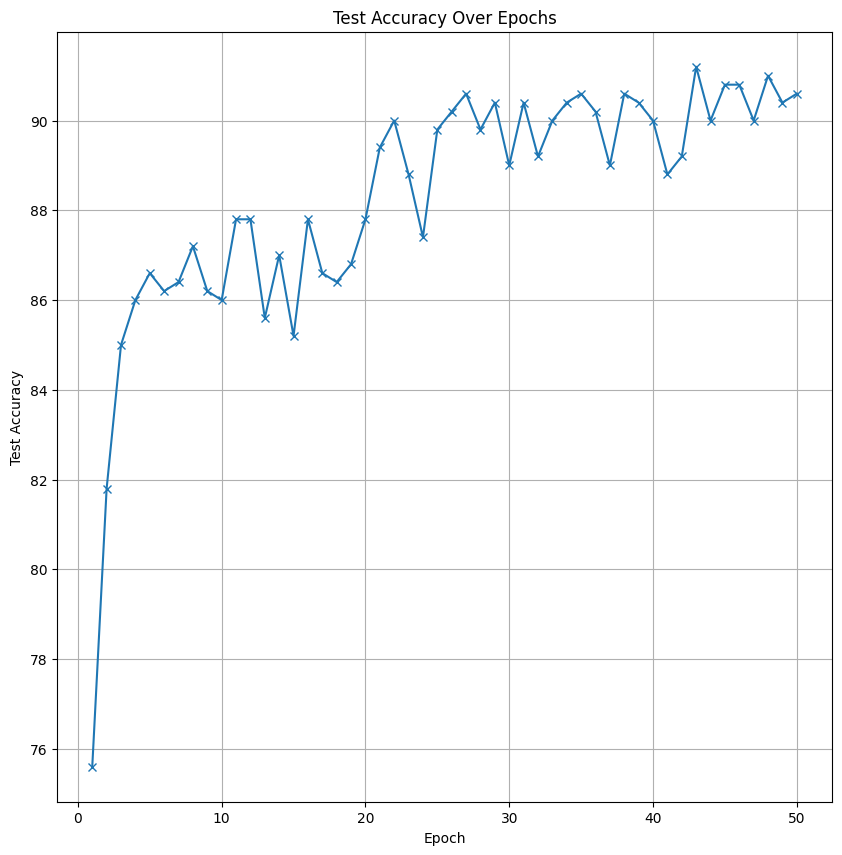

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
epochs = list(range(1, len(dev_acc_per_epoch)+1))
plt.plot(epochs, dev_acc_per_epoch, marker='x', linestyle='-')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Get test accuracy and loss for test datatset

In [33]:
avg_valid_loss, accuracy = test(lstm_classifier_last, test_dataloader, device, loss_fn)

print("Avg test loss:", avg_valid_loss)
print("Accuracy:", accuracy)

Avg test loss: 0.9788705930113792
Accuracy: 92.80000000000001


# Train and test model with aggregation as max pooling

In [34]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [35]:
lstm_classifier_max = LSTMTextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,num_layer,True, device, aggregate='max')
lr = 0.001
optimizer = optim.Adam(lstm_classifier_max.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\1319915531.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).to(device))


In [36]:
dev_acc_per_epoch = train(lstm_classifier_max, train_dataloader, development_dataloader, optimizer, loss_fn, device, num_epochs=50)

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\3171075734.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text, labels, text_lengths  = torch.tensor(text).to(device), labels.to(device), text_lengths


Epoch 1/50, Train Loss: 1.3317, Validation Loss: 1.1950, Accuracy: 72.00%
Epoch 2/50, Train Loss: 1.1401, Validation Loss: 1.1176, Accuracy: 80.20%
Epoch 3/50, Train Loss: 1.1081, Validation Loss: 1.1211, Accuracy: 78.60%
Epoch 4/50, Train Loss: 1.0762, Validation Loss: 1.0734, Accuracy: 83.80%
Epoch 5/50, Train Loss: 1.0507, Validation Loss: 1.0488, Accuracy: 85.40%
Epoch 6/50, Train Loss: 1.0314, Validation Loss: 1.0440, Accuracy: 86.20%
Epoch 7/50, Train Loss: 1.0114, Validation Loss: 1.0401, Accuracy: 85.60%
Epoch 8/50, Train Loss: 1.0322, Validation Loss: 1.0543, Accuracy: 86.00%
Epoch 9/50, Train Loss: 0.9999, Validation Loss: 1.0317, Accuracy: 87.80%
Epoch 10/50, Train Loss: 0.9812, Validation Loss: 1.0391, Accuracy: 87.00%
Epoch 11/50, Train Loss: 0.9737, Validation Loss: 1.0450, Accuracy: 85.40%
Epoch 12/50, Train Loss: 0.9705, Validation Loss: 1.0452, Accuracy: 86.60%
Epoch 13/50, Train Loss: 0.9658, Validation Loss: 1.0284, Accuracy: 87.20%
Epoch 14/50, Train Loss: 0.9605, V

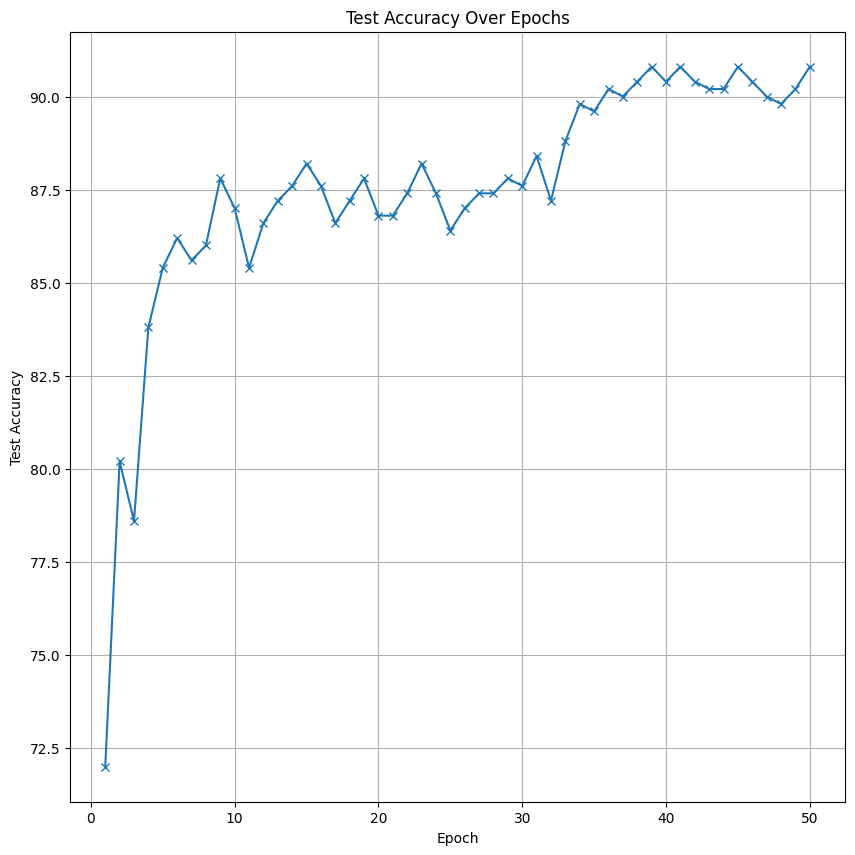

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
epochs = list(range(1, len(dev_acc_per_epoch)+1))
plt.plot(epochs, dev_acc_per_epoch, marker='x', linestyle='-')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [38]:
avg_valid_loss, accuracy = test(lstm_classifier_max, test_dataloader, device, loss_fn)

print("Avg test loss:", avg_valid_loss)
print("Accuracy:", accuracy)

Avg test loss: 0.9823838844895363
Accuracy: 92.4


# Train and test model with aggregation as average pooling

In [39]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [40]:
lstm_classifier_avg = LSTMTextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,num_layer,True, device, aggregate='average')
lr = 0.001
optimizer = optim.Adam(lstm_classifier_avg.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\1319915531.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix).to(device))


In [41]:
dev_acc_per_epoch = train(lstm_classifier_avg, train_dataloader, development_dataloader, optimizer, loss_fn, device, num_epochs=50)

C:\Users\mdzak\AppData\Local\Temp\ipykernel_3152\3171075734.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text, labels, text_lengths  = torch.tensor(text).to(device), labels.to(device), text_lengths


Epoch 1/50, Train Loss: 1.4587, Validation Loss: 1.3483, Accuracy: 57.80%
Epoch 2/50, Train Loss: 1.3383, Validation Loss: 1.2658, Accuracy: 66.40%
Epoch 3/50, Train Loss: 1.2280, Validation Loss: 1.2173, Accuracy: 68.80%
Epoch 4/50, Train Loss: 1.1652, Validation Loss: 1.1665, Accuracy: 75.00%
Epoch 5/50, Train Loss: 1.1258, Validation Loss: 1.1202, Accuracy: 79.40%
Epoch 6/50, Train Loss: 1.1104, Validation Loss: 1.1184, Accuracy: 79.20%
Epoch 7/50, Train Loss: 1.0947, Validation Loss: 1.1511, Accuracy: 75.00%
Epoch 8/50, Train Loss: 1.0815, Validation Loss: 1.1109, Accuracy: 79.20%
Epoch 9/50, Train Loss: 1.0895, Validation Loss: 1.1302, Accuracy: 77.60%
Epoch 10/50, Train Loss: 1.0711, Validation Loss: 1.0777, Accuracy: 82.80%
Epoch 11/50, Train Loss: 1.0486, Validation Loss: 1.0786, Accuracy: 83.80%
Epoch 12/50, Train Loss: 1.0677, Validation Loss: 1.0595, Accuracy: 84.60%
Epoch 13/50, Train Loss: 1.0334, Validation Loss: 1.0605, Accuracy: 85.00%
Epoch 14/50, Train Loss: 1.0228, V

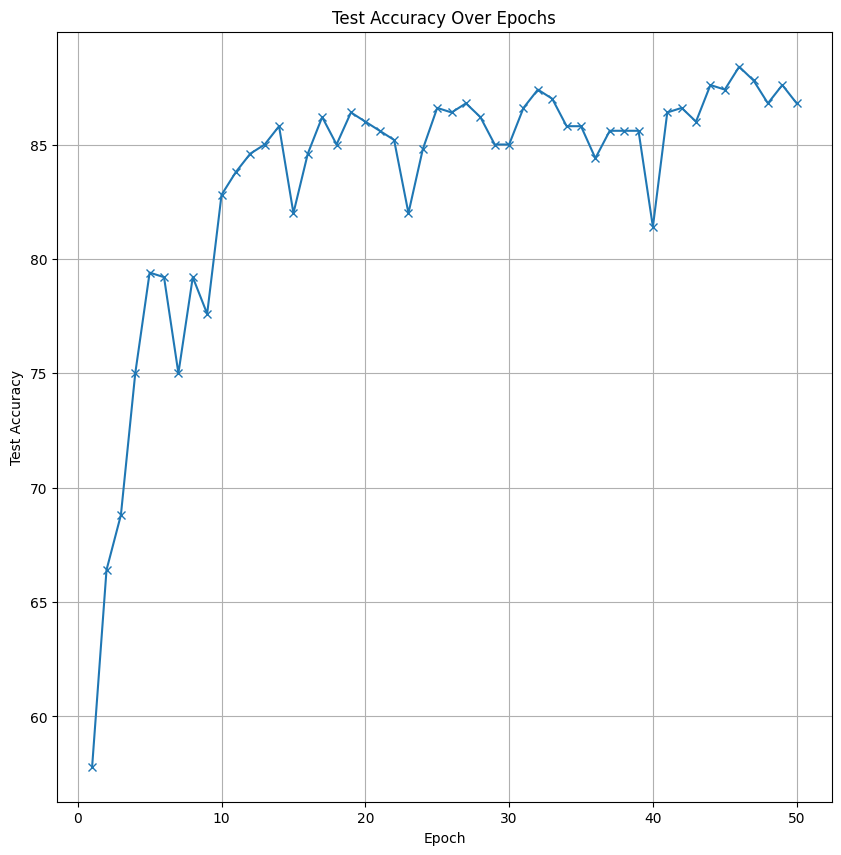

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
epochs = list(range(1, len(dev_acc_per_epoch)+1))
plt.plot(epochs, dev_acc_per_epoch, marker='x', linestyle='-')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [43]:
avg_valid_loss, accuracy = test(lstm_classifier_avg, test_dataloader, device, loss_fn)

print("Avg test loss:", avg_valid_loss)
print("Accuracy:", accuracy)

Avg test loss: 1.0008050464093685
Accuracy: 90.2
